# Seat availability at La Permanence: a first look at the data

[La Permanence](https://www.la-permanence.com) is a coworking space with two locations in Paris (*rue du Fer à Moulin* and *rue d'Alésia*).  Our purpose in this repository is to model and then predict the number the available seats, and this will be done in separate notebooks.  In this notebook, our goal is simply to familiarize ourselves with the data.  The steps taken in this notebook will be performed as a preliminary to most other notebooks, without explanation.

## Imports

In [1]:
import datetime
import os
import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [2]:
# Timezones
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_paris = pytz.timezone("Europe/Paris")  # locations are in Paris, France

# Resampling rule: resolution of time regularization
RESOL = 10
RULE = f"{RESOL}T"

days_of_the_week = {0: 'Monday',
                    1: 'Tuesday', 
                    2: 'Wednesday',
                    3: 'Thursday',
                    4: 'Friday',
                    5: 'Saturday', 
                    6: 'Sunday'}

# Plotting
FIGSIZE = (16, 6)
ALPHA = 0.7
# Colors 
COL_ALESIA = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
COL_MOULIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COL_TRAIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
COL_VALID = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
COL_PREDICT = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]

## Data
The dataset is saved in a `csv` file located in `~/Projects/la_permanence/attendance.csv`.  

**Note**: `attendance.csv` is a misnomer, as the file actually records the number of *available* seats, rather than the number of seats used.  

### Metadata on the dataset

In [3]:
filename = 'attendance.csv'
foldername = 'Projects/la_permanence'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)
filesize = os.path.getsize(filepath)

COL_WIDTH = 20  # for display in this cell

if filesize > 1e6:
    print("{0}{1:d}MB".format("File size:".ljust(COL_WIDTH), filesize//int(1e6)))
elif filesize > 1e3:
    print("{0}{1:d}KB".format("File size:".ljust(COL_WIDTH), filesize//int(1e3)))
else:
    print("{0}{1:d}B".format("File size:".ljust(COL_WIDTH), filesize))

line_number = !wc -l < {filepath}
line_number = int(line_number[0])
print("{0}{1}".format("Number of rows:".ljust(COL_WIDTH), line_number))
first_row = !head -1 {filepath}
column_names = first_row[0].split(',')
print("{0}{1}".format("Names of columns:".ljust(COL_WIDTH), ", ".join(column_names)))

File size:          1MB
Number of rows:     44839
Names of columns:   timestamp, Moulin, Alésia


### More details on the columns
- `timestamp` gives the date and time (UTC) of data collection in the format `YYYY-MM-DD-hh-mm-ss` where 
  - `YYYY=`year,
  - `MM=`month,
  - `DD=`day,
  - `hh=`hour,
  - `mm=`minute,
  - `ss`=second;
- `Moulin` gives the number of available seats at the *rue du Fer à Moulin* location (maximum is 63);
- `Alésia` gives the number of available seats at the *rue d'Alésia* location (maximum is 82).  

### Load the data

In [4]:
%time
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d-%H-%M-%S')

raw_data = pd.read_csv(
    filepath,
    sep=',',
    dtype={'Moulin': np.uint8, 'Alésia': np.uint8},
    parse_dates=['timestamp'],
    date_parser=dateparse
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


### Adjusting for timezones

The `timestamp` values are in the UTC standard, while the coworking spaces are located in Paris, France:

In [5]:
%time
raw_data['timestamp'] = raw_data['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


### Time regularization

The data was collected at irregular times, as can be seen by zooming in on a short window frame:

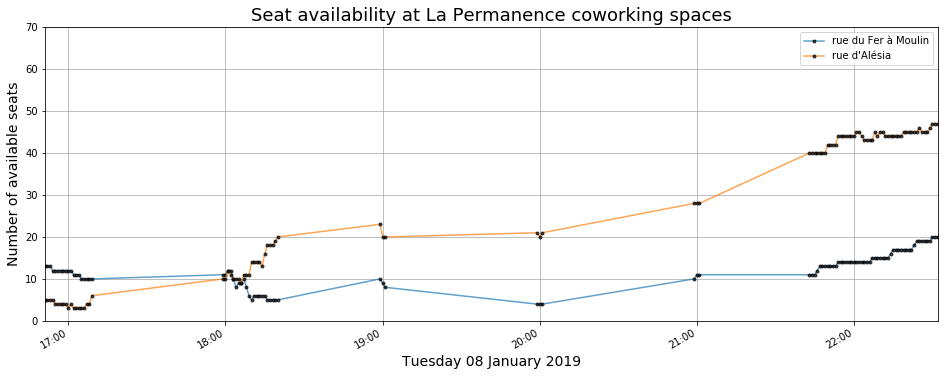

In [6]:
fig, ax = plt.subplots(figsize=FIGSIZE)
idx_range = range(100, 200)
window = raw_data.loc[idx_range, raw_data.columns]
the_day = window.loc[window.index.min(), 'timestamp']
the_hours = list(set([x.hour for x in  window.loc[idx_range, 'timestamp']]))

hour_range = pd.date_range(pd.Timestamp(the_day.year, the_day.month, the_day.day, the_day.hour), periods=the_hours[-1] - the_hours[0], freq= 'H')

window.set_index('timestamp').plot(style='-o', **{"markersize": 3, "markerfacecolor": "k", "markeredgecolor": "k"}, alpha=ALPHA, ax=ax);

ax.set_title("Seat availability at La Permanence coworking spaces", fontsize=18);

ax.set_ylabel("Number of available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));

ax.set_xlabel(the_day.strftime('%A %d %B %Y'), fontsize=14);
ax.set_xticks(hour_range);
ax.set_xticklabels([x.strftime("%H:00") for x in hour_range]);

ax.legend(["rue du Fer à Moulin", "rue d'Alésia"]);
ax.grid();

Thus we resample (at a resolution specified in `RULE`) and interpolate to regularize the data:

In [7]:
raw_data.set_index("timestamp", inplace=True)
raw_data = raw_data.resample(RULE).mean().interpolate().round().astype(np.uint8)
raw_data.reset_index('timestamp', inplace=True)

We obtain a regularized time-series:

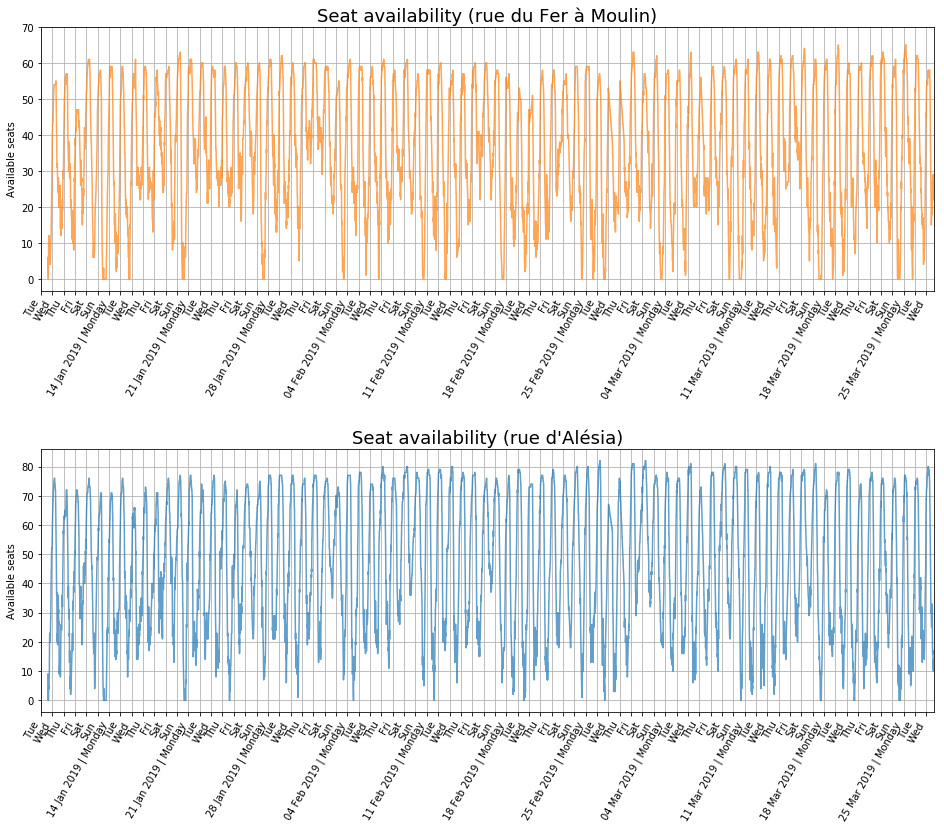

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14));

plt.subplots_adjust(hspace=0.6)

ts_min = raw_data['timestamp'].min()
ts_max = raw_data['timestamp'].max()
the_date_range = pd.date_range(ts_min.date(), ts_max.date());

# rue du Fer à Moulin
raw_data.plot(x='timestamp', y='Moulin', color=COL_MOULIN, alpha=0.7, ax=ax1);

ax1.set_title("Seat availability (rue du Fer à Moulin)", fontsize=18)

ax1.set_ylabel("Available seats");
ax1.set_yticks(range(0, 80, 10))

ax1.axes.get_xaxis().label.set_visible(False);
ax1.set_xticks(the_date_range);
ax1.set_xticklabels([pd.to_datetime(x).strftime("%d %b %Y | %A")
                     if x.weekday() in [0]
                     else pd.to_datetime(x).strftime("%a")
                     for x in the_date_range])
ax1.tick_params(axis='x', labelrotation=60)

ax1.get_legend().remove();
ax1.grid()

# rue d'Alésia
raw_data.plot(x='timestamp', y='Alésia', color=COL_ALESIA, alpha=0.7, ax=ax2);

ax2.set_title("Seat availability (rue d'Alésia)", fontsize=18)

ax2.set_ylabel("Available seats");
ax2.set_yticks(range(0, 90, 10))

ax2.axes.get_xaxis().label.set_visible(False);
ax2.set_xticks(the_date_range);
ax2.set_xticklabels([pd.to_datetime(x).strftime("%d %b %Y | %A")
                     if x.weekday() in [0]
                     else pd.to_datetime(x).strftime("%a")
                     for x in the_date_range])
ax2.tick_params(axis='x', labelrotation=60)

ax2.get_legend().remove();
ax2.grid()

# plt.savefig("La-Permanence-availability.png")

# Averaging

Our next goal is to have a representative for each day of the week and for the two locations separately.

In [9]:
moulin = raw_data.set_index('timestamp').drop('Alésia', axis=1)
moulin_by_day_of_week = pd.pivot_table(moulin, index=moulin.index.hour, columns=moulin.index.dayofweek, values='Moulin', aggfunc='mean')

In [10]:
alesia = raw_data.set_index('timestamp').drop('Moulin', axis=1)
alesia_by_day_of_week = pd.pivot_table(alesia, index=alesia.index.hour, columns=alesia.index.dayofweek, values='Alésia', aggfunc='mean')

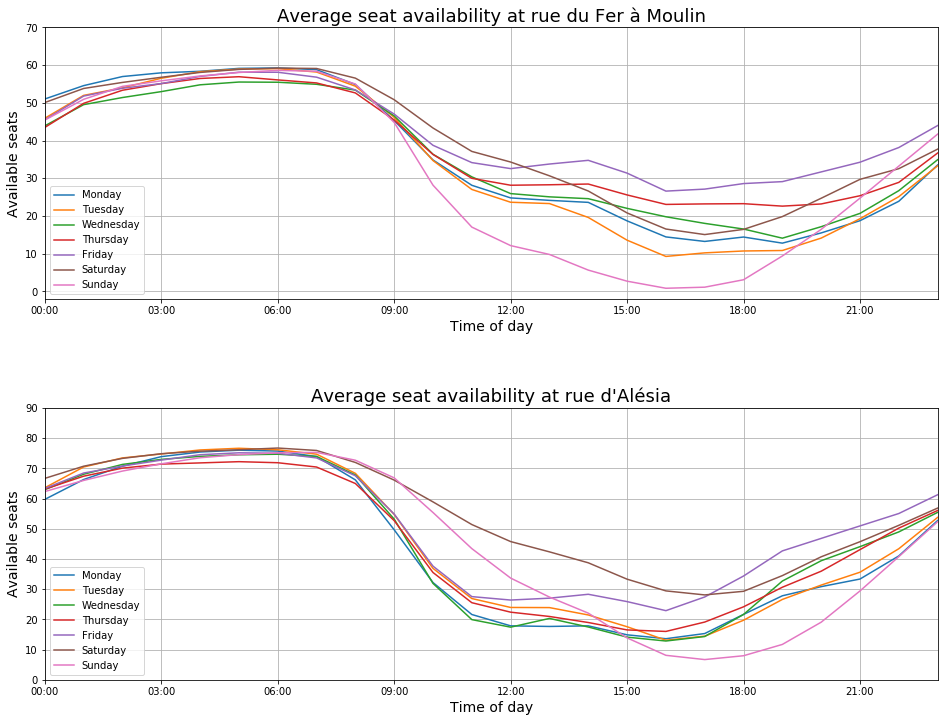

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

plt.subplots_adjust(hspace=0.4)

moulin_by_day_of_week.plot(ax=ax1);

ax1.set_title("Average seat availability at rue du Fer à Moulin", fontsize=18)
ax1.set_ylabel("Available seats", fontsize=14)
ax1.set_xlabel("Time of day", fontsize=14)

ax1.set_yticks(range(0, 80, 10))
ax1.set_xticks(range(0,24, 3))
ax1.set_xticklabels(["{:02d}:00".format(x) for x in ax1.get_xticks()])

ax1.legend(days_of_the_week.values())
ax1.grid()

alesia_by_day_of_week.plot(ax=ax2);

ax2.set_title("Average seat availability at rue d'Alésia", fontsize=18)
ax2.set_ylabel("Available seats", fontsize=14)
ax2.set_xlabel("Time of day", fontsize=14)

ax2.set_yticks(range(0, 100, 10))
ax2.set_xticks(range(0,24, 3))
ax2.set_xticklabels(["{:02d}:00".format(x) for x in ax1.get_xticks()])

ax2.legend(days_of_the_week.values())
ax2.grid()
# plt.savefig("la-permanence-average-availability.png")